In [68]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import XGate, QFT, TGate, HGate, SGate, CXGate, UGate, PhaseGate, ZGate, CPhaseGate
from qiskit.circuit.quantumregister import Qubit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from numpy import pi
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasisTranslator
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import gridspec
from functools import reduce

### Implementing the quantum phase estimation algorithm
We will implement the QPE algorithm for the unitary rotation operator:
$$R_{\phi} = \begin{bmatrix} 1 & 0 \\ 0 & e^{2\pi i \phi}\end{bmatrix}$$
We will consider the eigenvector $\ket{1}$, whith the corresponding eigenstate $e^{2\pi i \phi}$.
We choose $\phi = \frac{1}{8}$ which corresponds to the $T$ gate. The user is free to explore other values of $\phi$, but for simplicity the rest of the presented analysis will be based on the $T$ gate.


In [69]:
def non_local_standard(qc: QuantumCircuit, CU: CPhaseGate, comm1: QuantumRegister, comm2: QuantumRegister, 
                       target: QuantumRegister, control: Qubit, meas: int, classical: ClassicalRegister) -> QuantumCircuit:
    '''
    Apply the distributed version of the controlled unitary gate.
    Parameters
    ----------
    qc: the quantum circuit to apply the gate to
    CU: the unitary gate to be applied between two different quantum processors. In our case, the gate is the controlled phase gate
    comm1: the communication qubit of the first QPU (the type is quantum register, but it contains a single qubit)
    comm2: the communication qubit of the second QPU
    target: the target qubit of the controlled unitary. This qubit is prepared as the eigenvector of the unitary operator under 
    investigation, which is |1> in our case. (the type is quantum register, but it contains a single qubit)
    control: the qubit that acts as a control of the distributed controlled unitary gate being implemented
    meas: indexing of the classical register to help us perform measuremnts
    classical: the classical register to record the measurements

    Returns
    ---------
    qc: the quantum circuit after the distributed CU has been applied
    '''
    qc.h(comm1)
    qc.cx(comm1, comm2)
    qc.cx(target, comm2)
    qc.measure(comm2, meas)
    qc.append(XGate(),  [comm1]).c_if(classical[meas], 0)
    qc.append(XGate(),  [comm2]).c_if(classical[meas], 0)
    qc.append(CU, [comm1, control])
    qc.h(comm1)
    qc.measure(comm1, meas+1)
    qc.append(ZGate(), [target]).c_if(classical[meas+1], 0)
    qc.append(XGate(),  [comm1]).c_if(classical[meas+1], 0)
    return qc

In [70]:
def non_local_QFT_layer_combined(qc: QuantumCircuit, comm1: QuantumRegister, comm2: QuantumRegister, control: Qubit, 
                                 target_qubits: QuantumRegister, layer_num: int, meas: int, classical: ClassicalRegister) -> QuantumCircuit:
    ''' 
    As a part of the recursive QFT layer, group all operations that are targeting qubits belonging to the same 
    QPU and apply them as a single non-local gate.
    Parameters
    ----------
    qc: the quantum circuit to apply the gate to
    comm1: the communication qubit of the first QPU (the type is quantum register, but it contains a single qubit)
    comm2: the communication qubit of the second QPU
    control: the qubit that acts as the control of the distributed control of the current QFT layer
    target_qubits: all qubits that will be targeted in this layer of the QFT
    layer_num: the number of the current QFT layer
    meas: indexing of the classical register to help us perform measuremnts
    classical: the classical register to record the measurements

    Returns
    ---------
    qc: the quantum circuit after a part of the QFT layer has been applied
    '''
    qc.h(comm1)
    qc.cx(comm1, comm2)
    qc.barrier()
    qc.cx(control, comm2)
    qc.measure(comm2, meas)
    qc.append(XGate(),  [comm1]).c_if(classical[meas], 0)
    qc.append(XGate(),  [comm2]).c_if(classical[meas], 0)
    qc.barrier()
    for k, target in enumerate(target_qubits):
        l = - 2 * np.pi / 2 ** (len(target_qubits) + layer_num - k) 
        R = PhaseGate(l)
        CR = R.control(1)
        qc.append(CR, [comm1, target])
    qc.barrier()
    qc.h(comm1)
    qc.measure(comm1, meas+1)
    qc.append(ZGate(), [control]).c_if(classical[meas+1], 0)
    qc.append(XGate(),  [comm1]).c_if(classical[meas+1], 0)
    return qc

In [71]:
def QFT_layer(qc: QuantumCircuit, QPU_comm_used: list[QuantumRegister], QPU_working_used: list[QuantumRegister], 
              qubits_num: int, layer_num: int, meas: int, classical: ClassicalRegister) -> QuantumCircuit: 
    '''
    The implementation of a layer of the recursive QFT algorithm.
    Parameters
    ----------
    qc: the quantum circuit to apply the gate to
    QPU_comm_used: all of the communication qubits that are used to implement this layer
    QPU_working_used: all of the QPUs (their working qubits) used to implement this layer
    qubits_num: the number of working qubits of each QPU
    layer_num: the number of the current layer
    meas: indexing of the classical register to help us perform measuremnts
    classical: the classical register to record the measurements

    Returns
    ---------
    qc: the quantum circuit after the QFT layer has been applied
    
    '''
    for QPU_num, QPU_working in enumerate(QPU_working_used):
        # if we are not in the final QPU (the one with the control qubit), the control and the target are 
        # in different QPUs and we need a distributed gate
        if QPU_num != len(QPU_working_used) - 1:
            qc = non_local_QFT_layer_combined(qc=qc, comm1=QPU_comm_used[QPU_num], comm2=QPU_comm_used[-1], 
                                              control=QPU_working_used[-1][layer_num % qubits_num], target_qubits=QPU_working, 
                                              layer_num=(layer_num % qubits_num) + len(QPU_working_used) - QPU_num - 1, meas=meas, 
                                              classical=classical) 
        # if we are in the final QPU, we can apply all gates locally
        else:
            for j in range(layer_num % qubits_num):
                k = layer_num - j + 1
                l = - 2 * np.pi / 2 ** k
                R = PhaseGate(l)
                CR = R.control(1)
                qc.append(CR, [QPU_working[layer_num % qubits_num], QPU_working[j]])
        
    if layer_num>0:
        qc.h(QPU_working_used[-1][layer_num % qubits_num])
    return qc


In [72]:
def add_swaps(qc: QuantumCircuit, QPU_working: list[QuantumRegister], QPU_num: int,  qubits_num: int) -> QuantumCircuit:
    '''
    Swap the qubits before performing the recursive QFT.
    Parameters
    ----------
    qc: the quantum circuit to apply the gate to
    QPU_working: list of all QPU working registers
    QPU_num: the total number of QPUs
    qubits_num: the number of working qubits in each QPU

    Returns
    ---------
    qc: the quantum circuit after the swaps has been applied
    '''
    m = QPU_num * qubits_num 
    k = int(np.floor(m/2))
    for i in range(k):
        qc.swap(QPU_working[i // qubits_num][i % qubits_num], QPU_working[(m - i - 1) // qubits_num][(m - i - 1) % qubits_num])
    return qc

In [74]:
def QPE_circuit_distributed(QPU_num: int, qubits_num: int, swaps: bool) -> QuantumCircuit:
    '''
    Implement the distributed QPE algorithm on a specified number of QPUs.
    Parameters
    ----------
    QPU_num: the number of different QPUs
    qubits_num: the number of (working) qubits within each QPU
    swaps: whether to include SWAP gates in the QFT

    Returns
    ---------
    qc: the quantum circuit with a QPE implementation
    '''
    # define the unitary gate 
    U = TGate()
    # prepare the registers
    QPU_working = []
    QPU_comm = []
    q_registers = []
    for i in range(QPU_num):
        QPU_working.append(QuantumRegister(qubits_num, f"QPU{i}_w"))
        QPU_comm.append(QuantumRegister(1, f"QPU{i}_comm"))
        q_registers.append(QuantumRegister(qubits_num, f"QPU{i}_w"))
        q_registers.append(QuantumRegister(1, f"QPU{i}_comm"))
    qstate = QuantumRegister(1, f"QPU{qubits_num-1}_qstate")
    q_registers.append(qstate)
    classical = ClassicalRegister(2*qubits_num*QPU_num-2*qubits_num+qubits_num*QPU_num**2, "Classical") 
    qc = QuantumCircuit(*q_registers, classical)
    # put all of the working qubits in a superposition
    for i in range(QPU_num):
        qc.h(QPU_working[i])
    # prepare the state of the relevant eigenvector
    qc.x(qstate)

    # the first part of the QPE (controlled-U gates)
    meas = 0
    for i in range(QPU_num * qubits_num):
        qc.barrier()
        U2i = U.power(2**i)
        CU2i = U2i.control(1)
        if i < (QPU_num - 1) * qubits_num:
            qc = non_local_standard(qc, CU2i, QPU_comm[i // qubits_num], QPU_comm[-1], qstate, 
                                    QPU_working[i // qubits_num][i % qubits_num], meas, classical)
            meas += 2
        else:
            qc.append(CU2i, [QPU_working[i // qubits_num][i % qubits_num], qstate])
    # the second part of the QPE (recursive inverse QFT)
    if swaps:
        qc = add_swaps(qc, QPU_working, QPU_num, qubits_num)
    qc.append(QFT(qubits_num, inverse=True, do_swaps=False), QPU_working[0])
    for i in range(QPU_num * qubits_num - qubits_num ):
        QFT_layer(qc, QPU_comm[:(i // qubits_num + 1)+1], QPU_working[:(i // qubits_num + 1)+1], 
                  qubits_num, i, meas, classical)
        meas += 2 * (i // qubits_num + 1)
    # measure the working qubits
    meas2 = meas
    for QPU_w in QPU_working:
        qc.measure(QPU_w, range(meas2, meas2 + len(QPU_w), 1))
        meas2 += len(QPU_w)
    return qc

### Check the correctness

In [75]:
def process_counts(counts: dict[str, int], QPU_num: int, qubits_num: int) -> dict[str, int]:
    '''
    Truncate the measured bitstrings to take into account only relevant results.
    Parameters
    ----------
    counts: the results of the simulation
    QPU_num: the number of different QPUs
    qubits_num: the number of (working) qubits within each QPU

    Returns
    -------
    processed_counts: the counts after procesing
    '''
    processed_counts = defaultdict(int)
    for bitstring in counts:
        l = len(bitstring) 
        N = QPU_num * qubits_num
        new_bitstring = bitstring[0:N]
        processed_counts[new_bitstring] += counts[bitstring]
    return processed_counts

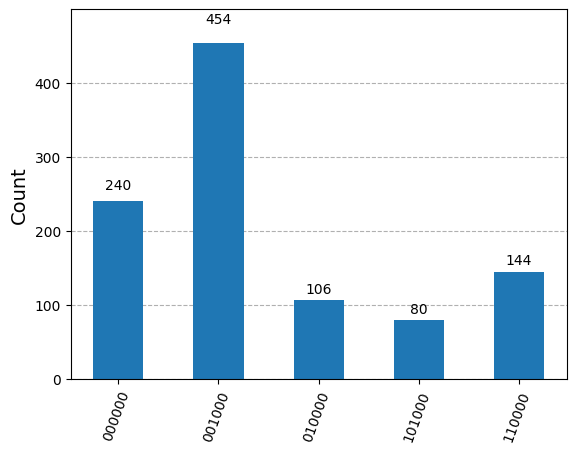

In [76]:
QPU_num = 2
qubits_num = 3
qc = QPE_circuit_distributed(QPU_num=QPU_num, qubits_num=qubits_num, swaps=True)
qc_decomposed = qc.decompose(reps=6)
simulator = AerSimulator()
result = simulator.run(qc_decomposed).result()
counts0 = result.get_counts(qc_decomposed)
counts = process_counts(counts0, QPU_num=QPU_num, qubits_num=qubits_num)
plot_histogram(counts)

Uncomment the following cell and run it if you would like to visualise the circuit:

In [77]:
# qc.draw()

In [78]:
def check_correct(counts: dict[str, int], QPU_num, qubits_num) -> bool:
    '''
    Check if we indeed get the phase of the eigenvector |1> of the T operator.
    Parameters
    ----------
    counts: the results of the simulation (already processed)
    QPU_num: the number of different QPUs
    qubits_num: the number of (working) qubits within each QPU

    Returns
    -------
    correct: whether the algorithm succesfully found the phase
    '''
    N = QPU_num * qubits_num
    max_bitstring = max(counts, key=counts.get)
    max_number = int(max_bitstring, 2)
    measured_phase = max_number / 2 ** N
    correct_phase = 1 / 8 
    correct = measured_phase == correct_phase
    return correct


In [79]:
check_correct(counts=counts, QPU_num=QPU_num, qubits_num=qubits_num)

True

## Quantum resource estimation

In [60]:
from azure.quantum.qiskit import AzureQuantumProvider
from azure.quantum import Workspace
workspace = Workspace ( 
    resource_id = , # Add your resource_id 
    location = "UK South"  # Add your workspace location (for example, "westus") 
) 

In [61]:
provider = AzureQuantumProvider(workspace)
backend = provider.get_backend('microsoft.estimator') 

In [62]:
items_min_qubits = [{"constraints": {"maxDuration": "100000000s"}}]
items_min_time = [{"constraints": {"maxPhysicalQubits": 10000000}}]

In [63]:
def QPE_circuit_equivalent_local(QPU_num: int, qubits_num: int, swaps: bool) -> QuantumCircuit:
    '''
    Implement the QPE algorithm on a single QPU with equivalent number of qubits to the distributed version.
    Parameters
    ----------
    QPU_num: the number of different QPUs
    qubits_num: the number of (working) qubits within each QPU
    swaps: whether to include SWAP gates in the QFT

    Returns
    ---------
    qc: the quantum circuit with a QPE implementation
    '''
    # every QPU has an extra communication qubit that we didn't explicitly count
    U = TGate()
    equivalent_qubits_num = QPU_num * qubits_num
    m = 1
    working_register = QuantumRegister(equivalent_qubits_num, "Working")
    quantum_state = QuantumRegister(m, "Psi")
    classical = ClassicalRegister(equivalent_qubits_num, "Classical")
    qc = QuantumCircuit(working_register, quantum_state, classical)
    qc.h([x for x in range(equivalent_qubits_num)])
    qc.x(equivalent_qubits_num)
    for i in range(equivalent_qubits_num):
        j = equivalent_qubits_num - 1 - i
        U2i = U.power(2**i)
        CU2i = U2i.control(1)
        qc.append(CU2i, [i, equivalent_qubits_num]) 
    qc.append(QFT(equivalent_qubits_num, inverse=True, do_swaps=swaps), [x for x in range(equivalent_qubits_num)])
    return qc

In [64]:
def find_factors(n: int) -> list[int]:
    '''
    Finds all factors of n smaller than n.
    '''
    factors = list(set(reduce(list.__add__, ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0))))
    factors.sort()
    factors.remove(max(factors))
    return factors


............................................................................................................................................................................................................................................................

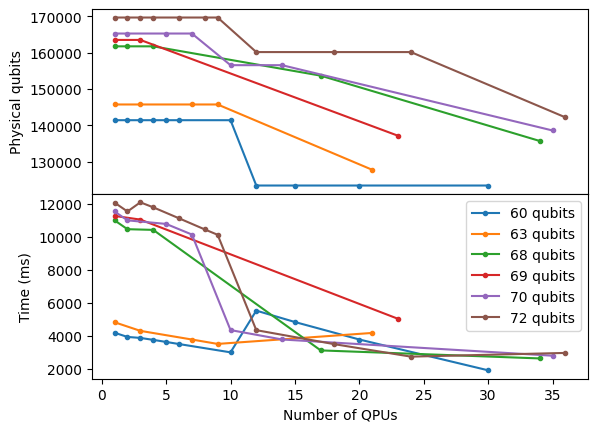

In [65]:
total_qubits_nums = [60, 63, 68, 69, 70, 72] # all working + all communication qubits
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex = ax0)
physical_qubits_all = []
QPU_sizes_all = []
for tot_qubits_num in total_qubits_nums:
    times = []
    physical_qubits = []
    QPU_sizes = []
    QPU_nums = find_factors(tot_qubits_num)
    for QPU_num in QPU_nums:
        QPU_sizes.append(tot_qubits_num // QPU_num)
        if QPU_num == 1:
            qc = QPE_circuit_equivalent_local(QPU_num=QPU_num, qubits_num=tot_qubits_num//QPU_num, swaps=False)
        else:
            qc = QPE_circuit_distributed(QPU_num=QPU_num, qubits_num=tot_qubits_num//QPU_num-1, swaps=False)
        job = backend.run(qc, items=items_min_qubits) # change items=items_min_time to minimise for runtime
        results = job.result()["physicalCounts"]
        physical_qubits.append(results["physicalQubits"])
        times.append(results["runtime"]/1e6) # ns->ms
    QPU_sizes_all.append(QPU_sizes)
    physical_qubits_all.append(physical_qubits)
    ax1.set_xlabel("Number of QPUs")
    ax0.set_ylabel("Physical qubits")
    ax0.plot(QPU_nums, physical_qubits, label=f"{tot_qubits_num} qubits", marker=".")
    ax1.set_ylabel("Time (ms)")
    ax1.plot(QPU_nums, times, label=f"{tot_qubits_num} qubits", marker=".")
    plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)
plt.legend()
plt.savefig("min_qubits_smallernumbers.pdf")
plt.show()

#### Comparing qubit technologies

.....................................................................................................................................................................................................................

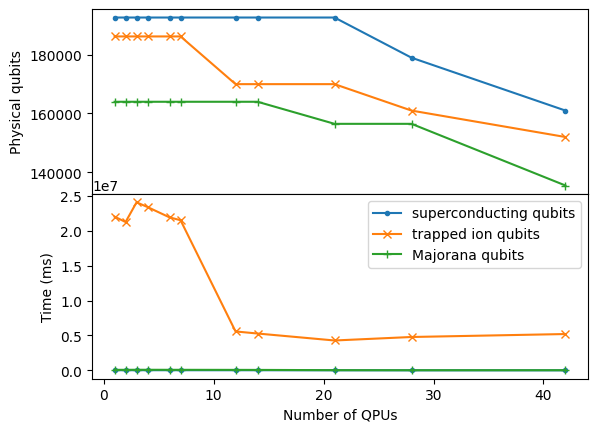

In [38]:
qubit_models_realistic = [{"name": "qubit_gate_ns_e3"}, {"name": "qubit_gate_us_e3"}, {"name": "qubit_maj_ns_e4"}]
# qubit_models_optimistic = [{"name": "qubit_gate_ns_e4"}, {"name": "qubit_gate_us_e4"}, {"name": "qubit_maj_ns_e6"}]
qubit_models_names = ["superconducting", "trapped ion", "Majorana"]
tot_qubits_num = 84
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex = ax0)
markers = [".", "x", "+"]
for i, qubit_model in enumerate(qubit_models_realistic):
    times = []
    physical_qubits = []
    QPU_nums = find_factors(tot_qubits_num)
    for QPU_num in QPU_nums:
        if QPU_num == 1:
            qc = QPE_circuit_equivalent_local(QPU_num=QPU_num, qubits_num=tot_qubits_num//QPU_num, swaps=False)
        else:
            qc = QPE_circuit_distributed(QPU_num=QPU_num, qubits_num=tot_qubits_num//QPU_num-1, swaps=False)
        job = backend.run(qc, items=items_min_qubits, qubitParams=qubit_model) 
        results = job.result()["physicalCounts"]
        physical_qubits.append(results["physicalQubits"])
        times.append(results["runtime"]/1e6) # ns->ms
    ax1.set_xlabel("Number of QPUs")
    ax0.set_ylabel("Physical qubits")
    ax0.plot(QPU_nums, physical_qubits, label=f"{qubit_models_names[i]} qubits", marker=markers[i])
    ax1.set_ylabel("Time (ms)")
    ax1.plot(QPU_nums, times, label=f"{qubit_models_names[i]} qubits", marker=markers[i])
    plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)
plt.legend()
plt.savefig("qubit_technologies_realistic.pdf")
plt.show()

#### Set different error budgets

.......................................................................................................................................................................................................................................................................................

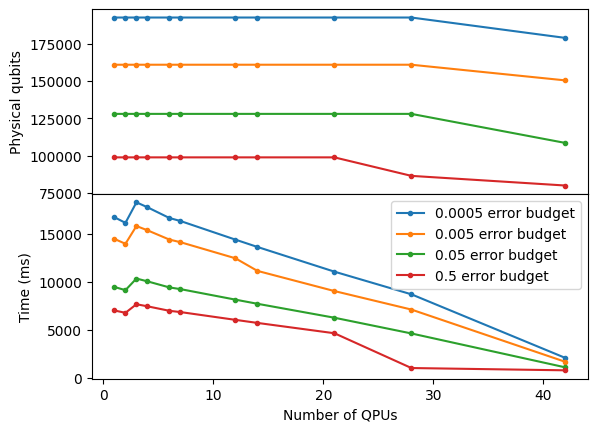

In [42]:
error_budgets = [0.0005, 0.005, 0.05, 0.5]
tot_qubits_num = 84
fig = plt.figure()
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex = ax0)
for error_budget in error_budgets:
    times = []
    physical_qubits = []
    QPU_nums = find_factors(tot_qubits_num)
    for QPU_num in QPU_nums:
        if QPU_num == 1:
            qc = QPE_circuit_equivalent_local(QPU_num=QPU_num, qubits_num=tot_qubits_num//QPU_num, swaps=False)
        else:
            qc = QPE_circuit_distributed(QPU_num=QPU_num, qubits_num=tot_qubits_num//QPU_num-1, swaps=False)
        job = backend.run(qc, items=items_min_qubits, errorBudget=error_budget) 
        results = job.result()["physicalCounts"]
        physical_qubits.append(results["physicalQubits"])
        times.append(results["runtime"]/1e6) # ns->ms
    ax1.set_xlabel("Number of QPUs")
    ax0.set_ylabel("Physical qubits")
    ax0.plot(QPU_nums, physical_qubits, label=f"{error_budget} error budget", marker=".")
    ax1.set_ylabel("Time (ms)")
    ax1.plot(QPU_nums, times, label=f"{error_budget} error budget", marker=".")
    plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)
plt.legend()
plt.savefig("error_budget.pdf")
plt.show()